<h1 style="text-align: center;">
<div style="color:grey; font-size: 0.6em; margin-bottom: 1em">Jakub Ostrzołek</div>
<div>WMM</div>
<div>Lab. 4 - przetwarzanie obrazów</div>
</h1>

## Przygotowanie
### Przygotowanie bibliotek i ścieżek do plików
Numer przydzielonego mi obrazu to:
$$310864 \; mod \; 36 = 4$$
, zatem będę pracował na obrazach `bikers_*.png`

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path
from IPython.display import display

data_dir = Path("./obrazy")
img_basename = "bikes"
img_paths = {key: str(path) for key, path in {
    "color"        : data_dir / "color"         / f"{img_basename}_col.png"       ,
    "color_inoise1": data_dir / "color_inoise1" / f"{img_basename}_col_inoise.png",
    "color_inoise2": data_dir / "color_inoise2" / f"{img_basename}_col_inoise.png",
    "color_noise"  : data_dir / "color_noise"   / f"{img_basename}_col_noise.png" ,
}.items()}

out_dir_root = Path("./out")

### Przygotowanie funkcji wyświetlającej (i zapisującej) obrazy
Przed wyświetleniem obrazka w `matplotlib` trzeba go przekonwertować na przestrzeń kolorów domyślnie wspieraną przez tę bibliotekę - RGB zamiast BGR. 

In [ ]:
def imshow(img: np.ndarray, img_title: str = "image",
           out_dir: str | Path = None, out_basename: str = None):
    plt.figure(figsize=(15, 10))
    plt.title(img_title)
    # bez skalowania wartości pikseli
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB, cmap="gray", vmin=0, vmax=255)
    plt.xticks([]), plt.yticks([])

    if out_dir is not None:
        out_dir = Path(out_dir)
        out_dir.mkdir(parents=True, exist_ok=True)
        if out_basename is None:
            out_filename = out_dir / f"{img_title}.png"
        else:
            out_filename = out_dir / out_basename
        cv2.imwrite(str(out_filename), img)

    plt.show()
    plt.close()


### Przygotowanie funkcji obliczającej PSNR

In [ ]:
def calcPSNR(img1: np.ndarray, img2: np.ndarray):
    imax = 255.**2  # zakładana wartość pikseli z przedziału [0, 255]

    # w różnicy obrazów istotne są wartości ujemne, dlatego img1 konwertowany
    # do typu np.float64 (liczby rzeczywiste) aby nie ograniczać wyniku do
    # przedziału [0, 255]

    # img1.size - liczba elementów w img1
    #   ==img1.shape[0]*img1.shape[1] dla obrazów mono,
    #   ==img1.shape[0]*img1.shape[1]*img1.shape[2] dla obrazów barwnych
    
    mse = ((img1.astype(np.float64) - img2)**2).sum() / img1.size
    return 10.0 * np.log10(imax / mse)


## Zadanie 1
### Treść zadania
> Zrealizować operację filtracji barwnego obrazu cyfrowego.
> 
> Do realizacji zadania wykorzystać obrazy zaszumione (szumem gaussowskim oraz impulsowym).
> 
> Każdy z obrazów wejściowych poddać przetwarzaniu filtrem wygładzającym (Gaussa) i filtrem
> medianowym. Każdy obraz wynikowy wyświetlić i obliczyć dla niego PSNR (w stosunku do obrazu
> oryginalnego, nie zaszumionego!, funkcja do obliczania PSNR dostępna jest w przykładowym
> skrypcie). Ocenić działanie filtrów dla masek o rozmiarach: 3x3, 5x5, 7x7.
> 
> Zebrać w tabeli PSNR dla różnych rodzajów szumów, filtrów i rozmiarów maski.
> * Jaki wpływ na skuteczność filtracji i na zniekształcenie obrazu ma rozmiar maski filtru?
> * Czy ocena subiektywna uzyskanych obrazów wynikowych, jest zgodna z PSNR (lepsza jakość – większy PSNR)?
> 
> Opisać wnioski w sprawozdaniu

### Przygotowanie danych
* oryginalny, niezaszumiony obraz
* lista obrazów zaszumionych różnymi typami szumów
* lista rozmiarów boku filtra
* lista tabel miar PSNR (dla każdego typu szumu osobno)
* bazowy folder na wygenerowane obrazy 

In [ ]:
# oryginalny obraz
img = cv2.imread(img_paths["color"])

# zaszumione obrazy
img_noise_names = ["color_inoise1", "color_inoise2", "color_noise"]
img_noise_paths = [img_paths[name] for name in img_noise_names]
imgs_noise = [cv2.imread(path) for path in img_noise_paths]

# rozmiary filrtów (jeden bok)
filter_sizes = [3, 5, 7]

# tabele z wynikowymi wartościami PSNR
psnrs_dfs = {name: pd.DataFrame() for name in img_noise_names}

# folder wyjściowy na wygenerowane obrazy
out_dir = out_dir_root / "zad1"


### Wygładzanie obrazów
Generowanie wygładzonych obrazów oraz obliczenie dla nich wartości miary PSNR.

In [ ]:
for img_noise, img_name in zip(imgs_noise, img_noise_names):
    psnrs_df = psnrs_dfs[img_name]
    for filter_size in filter_sizes:
        # filtr Gaussa
        # nałożenie filtra
        img_gauss = cv2.GaussianBlur(img_noise, (filter_size, filter_size), 0)
        # zapisanie wartości PSNR dla przefiltrowanego obrazu
        psnrs_df.loc[filter_size, "GaussianBlur"] = calcPSNR(img, img_gauss)
        # wyświetlenie i zapisanie obrazu
        img_title = f"{img_name} GaussianBlur filter_size={filter_size}"
        imshow(img_gauss, img_title, out_dir / img_name, f"gauss-{filter_size}.png")

        # filtr medianowy
        # nałożenie filtra
        img_med = cv2.medianBlur(img_noise, filter_size)
        # zapisanie wartości PSNR dla przefiltrowanego obrazu
        psnrs_df.loc[filter_size, "medianBlur"] = calcPSNR(img, img_med)
        # wyświetlenie i zapisanie obrazu
        img_title = f"{img_name} medianBlur filter_size={filter_size}"
        imshow(img_med, img_title, out_dir / img_name, f"med-{filter_size}.png" )


### Obserwacje subiektywne
* niezależnie od typu szumu i typu filtra, im większy rozmiar filtra tym gorszy jest wynik (mniej szczegółowy, bardziej rozmyty)
* dla szumu typu sól i pieprz lepiej sprawdzał się filtr medianowy, a dla szumu Gaussa - filtr Gaussa

### Wyświetlenie tabel z miarami PSNR

In [ ]:
for img_name, psnrs_df in psnrs_dfs.items():
    print(f"{img_name}: tabela PSNR")
    display(psnrs_df)


Miary PSNR zdają się oddawać moje odczucia. Im większa miara PSNR, tym ładniejszy obraz według mnie.

## Zadanie 2
### Treść zadania
> Zrealizować operację wyrównania histogramu dla obrazu barwnego i zapisać obraz wynikowy do
> pliku.
> 
> **UWAGA:** operację wyrównania histogramu należy wykonać wyłącznie dla składowej
> odpowiadającej za jasność, w tym celu należy wejściowy obraz RGB skonwertować do innej
> przestrzeni (np. YCbCr/YUV), a po wyrównaniu histogramu dla właściwej składowej powrócić do
> pierwotnego formatu.
> 
> Porównać uzyskane obrazy i ich histogramy (w szczególności: histogram dla składowej, dla której
> wykonano operację wyrównywania histogramu).  
> Czy obraz po wyrównaniu histogramu jest subiektywnie lepszej jakości?
### Przygotowanie danych

In [ ]:
# oryginalny obraz
img = cv2.imread(img_paths["color"])

# folder wyjściowy
out_dir = out_dir_root / "zad2"


### Wyrównanie histogramu
Oryginalny obraz został skonwertowany do przestrzeni kolorów YCrCb, a następnie przeprowadzono na nim wyrównanie histogramu luminancji. Na końcu przywrócono przetworzonemu obrazowi oryginalną przestrzeń kolorów.

In [ ]:
# generowanie obrazu z wyrównanym histogramem luminancji
# konwersja do YCrCb
img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
# wyrównanie histogramu luminancji
img_eq_YCrCb = np.copy(img_YCrCb)
img_eq_YCrCb[:, :, 0] = cv2.equalizeHist(img_YCrCb[:, :, 0])
# konwersja z powrotem do BGR
img_eq = cv2.cvtColor(img_eq_YCrCb, cv2.COLOR_YCrCb2BGR)

# porównanie obrazów
imshow(img, "oryginalny obraz")
imshow(img_eq, "obraz z wyrównanym histogramem", out_dir, "eq-luminance.png")


### Obserwacje subiektywne
Według mnie obraz po wyrównaniu histogramu luminancji stał się za jasny. Dodatkowo niektóre szczegóły zaczęły się zlewać, np. fałdy na ubraniach motocyklistów są w wielu miejscach dużo mniej widoczne. Mam wrażenie, jakby sceneria była oświetlona sztucznym, agresywnym, białym światłem, zamiast naturalnym - słonecznym.

### Porównanie histogramów
Zaimplementowana została funkcja `compare_histograms`, która tworzy histogram dwóch obrazów (o jednym kanale) na jednym wykresie, w celu łatwego ich porównania.

Następnie funkcja ta została wywołana dla wszystkich kanałów obrazu w przestrzeni BGR oraz dla kanału lumimancji obrazu w przestrzeni YCrCb (nie była wywoływana dla obu kanałów chrominancji, ponieważ nie były one modyfikowane)

In [ ]:
def compare_histograms(img1: np.ndarray, img2: np.ndarray,
                       label1: str = None, label2: str = None,
                       title: str = None,
                       out_dir: str | Path = None, out_basename: str = None):
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.hist(img1.flatten(), 256, range=(0, 255), alpha=0.5, label=label1)
    plt.hist(img2.flatten(), 256, range=(0, 255), alpha=0.5, label=label2)
    plt.xlim((0, 255))
    plt.legend()

    if out_dir is not None:
        out_dir = Path(out_dir)
        out_dir.mkdir(parents=True, exist_ok=True)
        if out_basename is None:
            out_filename = out_dir / f"{img_title}.png"
        else:
            out_filename = out_dir / out_basename
        plt.savefig(out_filename)

    plt.show()
    plt.close()


compare_histograms(img[:, :, 0], img_eq[:, :, 0],
                   label1="oryginał", label2="równy hist.\nluminancji",
                   title="kolor niebieski",
                   out_dir=out_dir / "hist", out_basename="blue.png")
compare_histograms(img[:, :, 0], img_eq[:, :, 1],
                   label1="oryginał", label2="równy hist.\nluminancji",
                   title="kolor zielony",
                   out_dir=out_dir / "hist", out_basename="green.png")
compare_histograms(img[:, :, 0], img_eq[:, :, 2],
                   label1="oryginał", label2="równy hist.\nluminancji",
                   title="kolor czerwony",
                   out_dir=out_dir / "hist", out_basename="red.png")
compare_histograms(img_YCrCb[:, :, 0], img_eq_YCrCb[:, :, 0],
                   label1="oryginał", label2="równy hist.\nluminancji",
                   title="luminancja",
                   out_dir=out_dir / "hist", out_basename="luminance.png")


### Obserwacje
* poprzez wyrównanie histogramu luminancji, histogramy wszystkich kanałów przestrzeni BGR również zostały wyrównane, 'spłaszczone'
* w wyrównanym histogramie widać dużo pustych wartości - może to być przyczyna wrażenia zlewania się kolorów, ponieważ ok. 40% poziomów luminancji nie jest w ogóle wykorzystywanych

## Zadanie 3
### Treść zadania
> Korzystając z filtru Laplace’a do wyznaczenia wysokoczęstotliwościowych składowych obrazu
> dokonać wyostrzenia obrazu:
> 
> `img_out = img_in + W*img_laplace`
> 
> Jaki jest wpływ wagi składowej wysokoczęstotliwościowej na postać obrazu wynikowego?  
> Dla jakich wartości tej wagi uzyskuje się dobre, przyjemne dla oka wyniki?
> 
> **Uwaga:** należy pamiętać, że wyostrzanie obrazu powoduje również uwydatnienie szumu w obrazie, w
> niektórych przypadkach (niezbyt dobrej jakości obrazów oryginalnych) przydatne może być wstępne
> wygładzenie obrazu filtrem dolnoprzepustowym (np. filtrem Gaussa).
> Wskazówka: wykorzystać funkcję `cv2.addWeighted()` do sumowania obrazów i równoczesnej
> konwersji wyniku do 8-bitowych liczb całkowitych z przedziału `[0, 255]`.
> 
> **Uwaga:** ze względu na sposób wyliczania laplasjanu w bibliotece OpenCV w celu uzyskania
> ‘dobrych’ wyników należy odjąć ‘obraz wysokoczęstotliwościowy’, czyli zastosować ujemne
> wartości wagi W.
### Przygotowanie danych

In [ ]:
# oryginalny obraz
img = cv2.imread(img_paths["color"])

# folder wyjściowy
out_dir = out_dir_root / "zad3"


### Filtr Laplace'a
W celu sensownego wyświetlenia filtru Laplace'a przeprowadziłem normalizację wartości absolutnej wyjścia funkcji `cv2.Laplacian()`. Tak spreparowany obraz służy tylko do wyświetlania - nie nadaje się dobrze do wyostrzania poprzez nałożenie go na oryginalny obraz.

In [ ]:
# filtr Laplace'a
# do wyświetlania została wzięta jego wartość absolutna i został znormalizowany,
# ponieważ miał wartości daleko wychodzące poza zakres 0..255
img_laplace = cv2.Laplacian(img, cv2.CV_64F)
img_laplace_norm = cv2.normalize(
    abs(img_laplace),
    None,
    alpha=0,
    beta=255,
    norm_type=cv2.NORM_MINMAX,
    dtype=cv2.CV_8U)

# porównanie obrazów
imshow(img, "oryginalny obraz")
imshow(img_laplace_norm, "filtr Laplace'a",
       out_dir=out_dir, out_basename="laplace-filter.png")


### Wyostrzenie krawędzi
Filtr (ten bez wartości absolutnej i normalizacji) jest nakładany na obraz oryginalny z różnymi wagami.

In [ ]:
# nałożenie filtru laplace'a na oryginalny obraz z różnymi wagami
weights = [0.2, 0.35, 0.5, 0.65, 0.8, 1]
for weight in weights:
    img_sharpened = cv2.addWeighted(img, 1, img_laplace, -weight, 0,
                                    dtype=cv2.CV_8U)
    weight_str = f"{weight:.2f}".replace(".", ",")
    imshow(img_sharpened, f"obraz wyostrzony z wagą {weight}",
           out_dir=out_dir, out_basename=f"sharpened-{weight_str}.png")


### Obserwacje subiektywne
* im wyższa waga składowej wysokoczęstotliwościowej tym ostrzejsze stają się szczegóły na obrazie
* wyostrzenie z wagą 0.2 daje najlepszy efekt - szczegóły takie jak napisy na ubraniach stają się czytelniejsze, bez wprowadzania nadmiernych efektów ubocznych
* użycie wyższych wag zbyt mocno uwypukla szum oraz sztucznie rozjaśnia fragmenty z dużą liczbą krawędzi, np. szyprychy w kołach motocykli lub grudki ziemi

### Wygładzenie obrazu filtrem Gaussa przed wyostrzeniem krawędzi
Tym razem przed operacją wyostrzenia została zastosowana operacja wygładzenia obrazu filtrem Gaussa

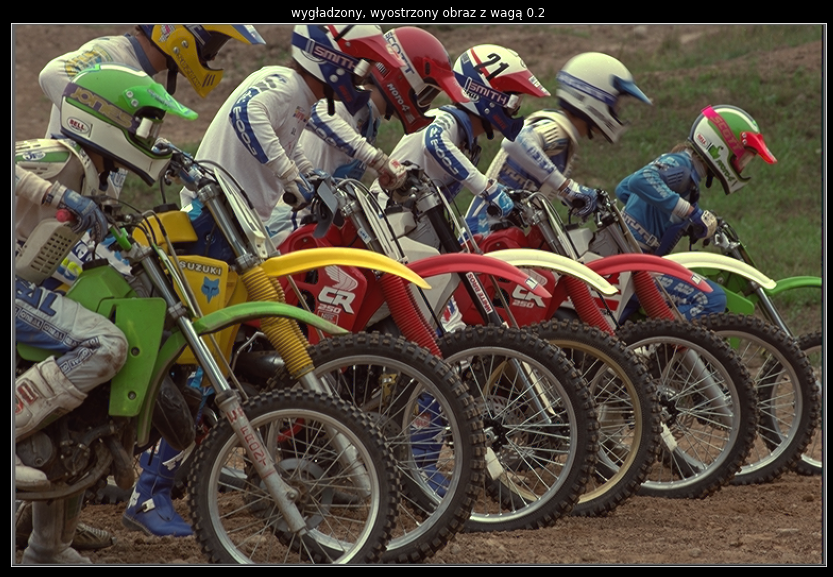

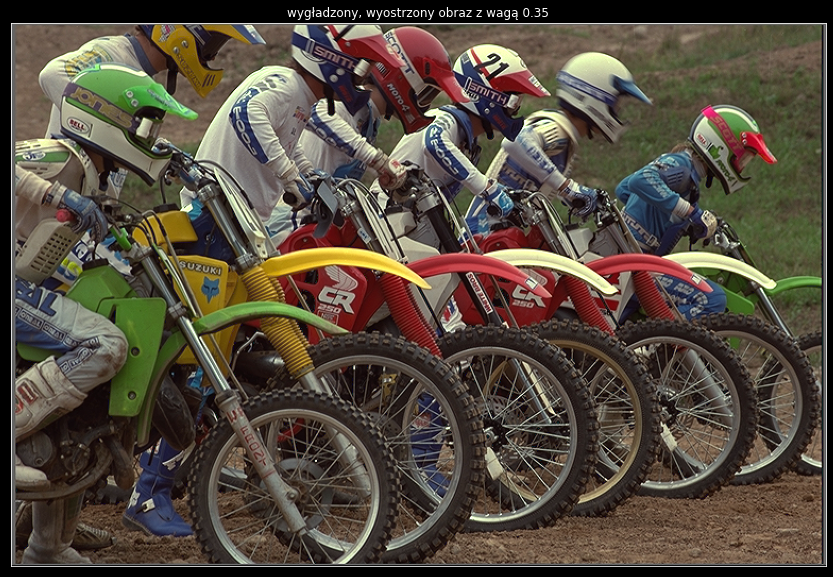

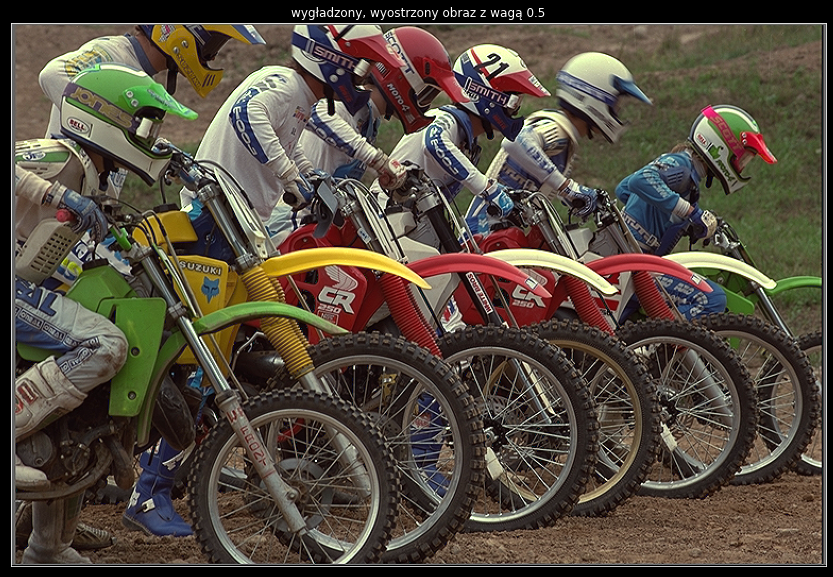

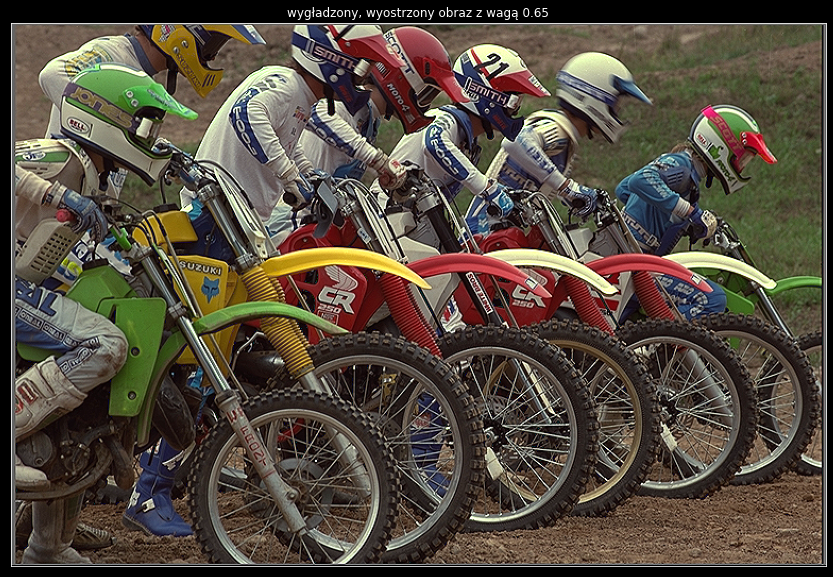

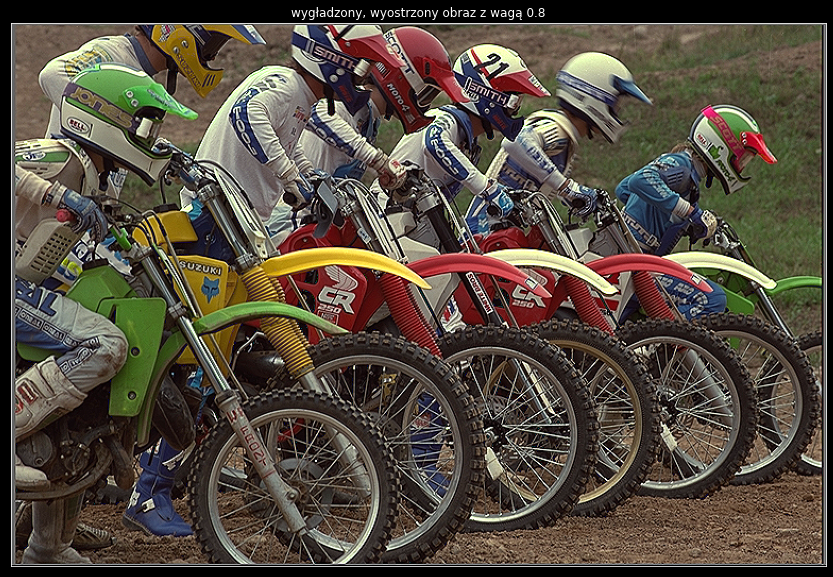

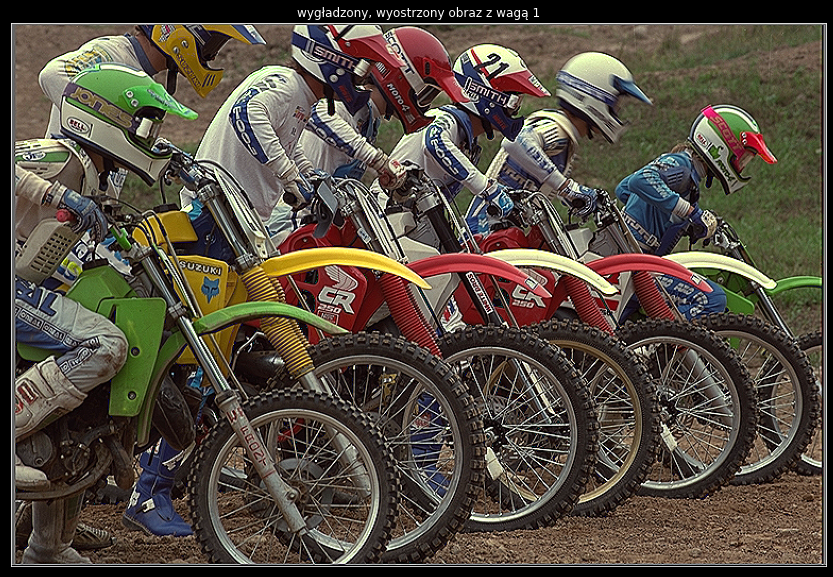

In [26]:
# obraz wygładzony filterm Gaussa
img_gauss = cv2.GaussianBlur(img, (3, 3), 0)

# nałożenie filtru laplace'a na wygładzony obraz z różnymi wagami
weights = [0.2, 0.35, 0.5, 0.65, 0.8, 1]
for weight in weights:
    img_sharpened = cv2.addWeighted(img_gauss, 1, img_laplace, -weight, 0,
                                    dtype=cv2.CV_8U)
    weight_str = f"{weight:.2f}".replace(".", ",")
    imshow(img_sharpened, f"wygładzony, wyostrzony obraz z wagą {weight}",
           out_dir=out_dir / "pre-gauss", out_basename=f"sharpened-{weight_str}.png")


### Obserwacje subiektywne
* teraz można pozwolić sobie na wyższe wagi, bez narażania się na ryzyko zbytniego podbicia szumu
* dalej zostaje efekt sztucznego rozjaśnienia fragmentów z dużą ilością krawędzi (szprych), przy zbyt dużych wagach
* tym razem waga 0.35 daje najlepszy efekt - lepszy niż waga 0.2 bez uprzedniego przepuszczenia przez filtr Gaussa